# Testen verschiedener ML-Modelle
**Ziel: mit den Daten eines Tages die Konzentration oder AQI-Wert eines Schadstoffes vorhersagen**
Sinnvolle Szenarien für eine Anwendung sind dabei:
- Die Messung eines bestimmten Schadstoffes fällt z.B. wegen eines technischen Defekts aus. Dennoch ist es weiterhin wichtig den Schadstoff zu erfassen um bei hoher Belastung Gegenmaßnahmen zu ergreifen.
- Anwendung in Staaten mit geringem Vertrauen in die kommunale/staatlichen Organe, da diese möglicherweiße die Konzentrationen eines problematischen Schadstoffes fälschen könnten. 
- In kleineren Städten könnte nach einer Lernphase (Zeit in die Stadt z.B. eine Ozon-Messstadion besitzt) auch auf lange Sicht (falls also kein Sensor mehr vorhanden ist) trotzdem noch Werte für den Schadstoff berechnet werden und so auch Verhaltensempehlungen an die Bevölkerung bei einer hohen Schadstoffbelastung abgegeben werden. Dabei ist jedoch die Vorhersagekraft des Modells genau zu überprüfen.     

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import decomposition, neighbors, ensemble,tree,metrics,model_selection,svm
from sklearn.pipeline import Pipeline



In [2]:
'Laden der DF'
pollution = pd.read_hdf("Pollution_Data/pollutant_data.h5")
predictor = pd.read_hdf("Predictor_Data/all.h5")
kalender = pd.read_hdf("Predictor_Data/kalender.h5")
pollution.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7571 entries, 2000-01-01 to 2022-09-30
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   mean_co        7503 non-null   float64 
 1   max_value_co   7503 non-null   float64 
 2   max_hour_co    7503 non-null   float64 
 3   mean_so2       7054 non-null   float64 
 4   max_value_so2  7054 non-null   float64 
 5   max_hour_so2   7054 non-null   float64 
 6   mean_no2       7075 non-null   float64 
 7   max_value_no2  7075 non-null   float64 
 8   max_hour_no2   7075 non-null   float64 
 9   mean_o3        7344 non-null   float64 
 10  max_value_o3   7344 non-null   float64 
 11  max_hour_o3    7344 non-null   float64 
 12  mean_pm2_5     6742 non-null   float64 
 13  aqi_pm2_5      6742 non-null   category
 14  aqi_so2        7054 non-null   category
 15  aqi_no2        7075 non-null   category
 16  aqi_o3         7344 non-null   category
 17  aqi_idxmax     

## Lineare Modelle zur Vorhersage der O3-Konzentration
**nur mit Predictor-Daten**
### Preprocessing 
- entfernen aller nan-Werte 
- Standartisieren um zu gewährleisten das auch Feature mit kleiner Varianz gewichtet werden und mit anderen vergleichbar sind


In [3]:
predict_today=kalender.join(predictor)
# hinzufügen der Schadstoff Werte (ohne max_hour)
predict_today = predict_today.join(pollution.drop(['max_hour_co', 'max_hour_so2',
                                                   'max_hour_no2','max_hour_o3',"aqi_idxmax"],axis=1))
predict_today=predict_today.drop(['max_hour_temp',  'max_hour_humidity', 'max_hour_radiation', 'max_hour_uv_radiation','max_hour_pressure', ],axis=1)
predict_today_dropna=predict_today.dropna()
predict_today_dropna.shape

(1599, 54)

Nach dem entfernen der np.nan Werte bleiben von den vorher fast 7.000 Werten nur noch 1.600 übrig (eigentlich zu wenige)

In [4]:
predict_today.columns

Index(['day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'businness_day', 'PRCP', 'TMAX', 'TMIN', 'AWND', 'WSF2', 't_minmax',
       'mean_temp', 'max_value_temp', 'mean_humidity', 'max_value_humidity',
       'mean_radiation', 'max_value_radiation', 'mean_uv_radiation',
       'max_value_uv_radiation', 'mean_pressure', 'max_value_pressure',
       'wind_north', 'wind_south', 'wind_east', 'wind_west', 'mean_co',
       'max_value_co', 'mean_so2', 'max_value_so2', 'mean_no2',
       'max_value_no2', 'mean_o3', 'max_value_o3', 'mean_pm2_5', 'aqi_pm2_5',
       'aqi_so2', 'aqi_no2', 'aqi_o3', 'aqi_max'],
      dtype='object')

In [5]:
'Standartisieren'
col_to_scale=['PRCP', 'TMAX', 'TMIN', 'AWND', 'WSF2', 't_minmax', # only numeric columns
       'mean_temp', 'max_value_temp', 'mean_humidity', 'max_value_humidity',
       'mean_radiation', 'max_value_radiation', 'mean_uv_radiation',
       'max_value_uv_radiation', 'mean_pressure', 'max_value_pressure',
       'mean_co',
       'max_value_co', 'mean_so2', 'max_value_so2', 'mean_no2',
       'max_value_no2', 'mean_o3', 'max_value_o3', 'mean_pm2_5',] 
st_scaler=StandardScaler()
predict_today_dropna[col_to_scale] = st_scaler.fit_transform(predict_today_dropna[col_to_scale])

'Split in train and test data'
predict_column="max_value_o3"
X_train , X_test , y_train , y_test = train_test_split(predict_today_dropna.drop(['aqi_pm2_5','aqi_so2',
                                                                           'aqi_no2','aqi_o3',predict_column,"mean_o3","aqi_max"],axis=1),
                                                       predict_today_dropna[predict_column])



/tmp/ipykernel_8068/1243780871.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_today_dropna[col_to_scale] = st_scaler.fit_transform(predict_today_dropna[col_to_scale])


### OLS 
einfachstes lineares Modell, minimiert die Summer der Fehlerquadrate.  
Dabei sind insbesondere die Koeffizenten recht anschaulich um Zusammenhänge zu verstehen: So z.B. das bei hohen Temperaturen die O3-Konzentration steigt.

Score of the model: 0.6553741298522295


Text(0.5, 1.0, 'Koeffizenten des OLS-Modells')

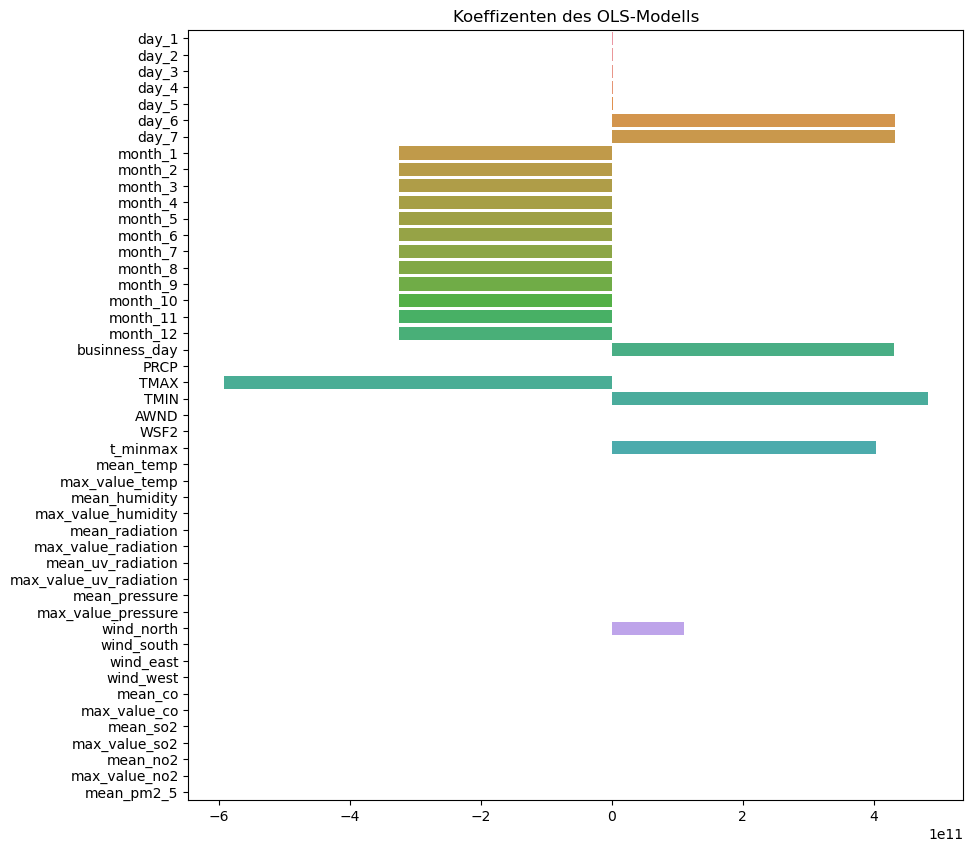

In [6]:
#einfachstes Modell -> linear
lin_reg=LinearRegression()
lin_reg.fit(X_train,y_train)
score= lin_reg.score(X_test,y_test)
print(f"Score of the model: {score}")
fig_coef, ax_coef = plt.subplots(1,1,figsize=(10,10))
ax_coef = sns.barplot(y=X_train.columns,x=lin_reg.coef_,orient="h")
ax_coef.set_title("Koeffizenten des OLS-Modells")

R2: 0.6553741298522295


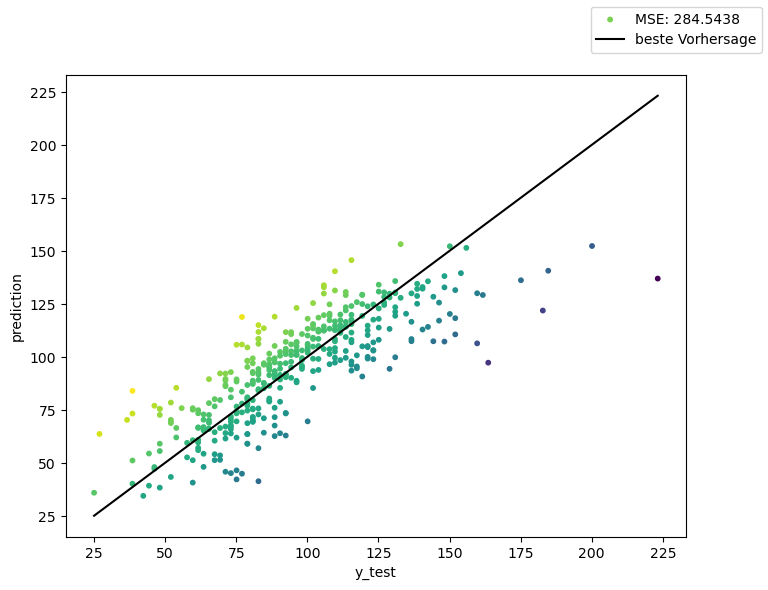

In [7]:
lin_reg_fig, lin_reg_ax= plt.subplots(1,1,figsize=(8,6))

st_scaler_attributes=pd.DataFrame(data={"mean":st_scaler.mean_,"var":np.sqrt(st_scaler.var_)},index=col_to_scale)
#Formula for reverse st_scaling x= z*s + u
y_true= y_test * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
y_predict = lin_reg.predict(X_test) * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
error = y_predict-y_true

mse=mean_squared_error(y_true=y_true,y_pred=y_predict)
lin_reg_ax.scatter(y_true,y_predict,s=10,c=error,cmap="viridis",label=f"MSE: {np.round(mse,4)}")
x=np.linspace(y_true.min(),y_true.max())
lin_reg_ax.plot(x,x,c="black",label="beste Vorhersage")
lin_reg_ax.set_xlabel("y_test")
lin_reg_ax.set_ylabel("prediction")
lin_reg_fig.legend()
print(f"R2: {metrics.r2_score(y_true,y_predict)}")


### Ridge Regression 
Dieses Modell ist sehr ähnlich zu OLS, versucht aber hohe Koeffizienten zu vermeiden -> kaum Unterschiede zum vorherigen Modell

Score of the model: 0.6563675817119009


Text(0.5, 1.0, 'Koeffizenten des Ridge-Regression-Modells')

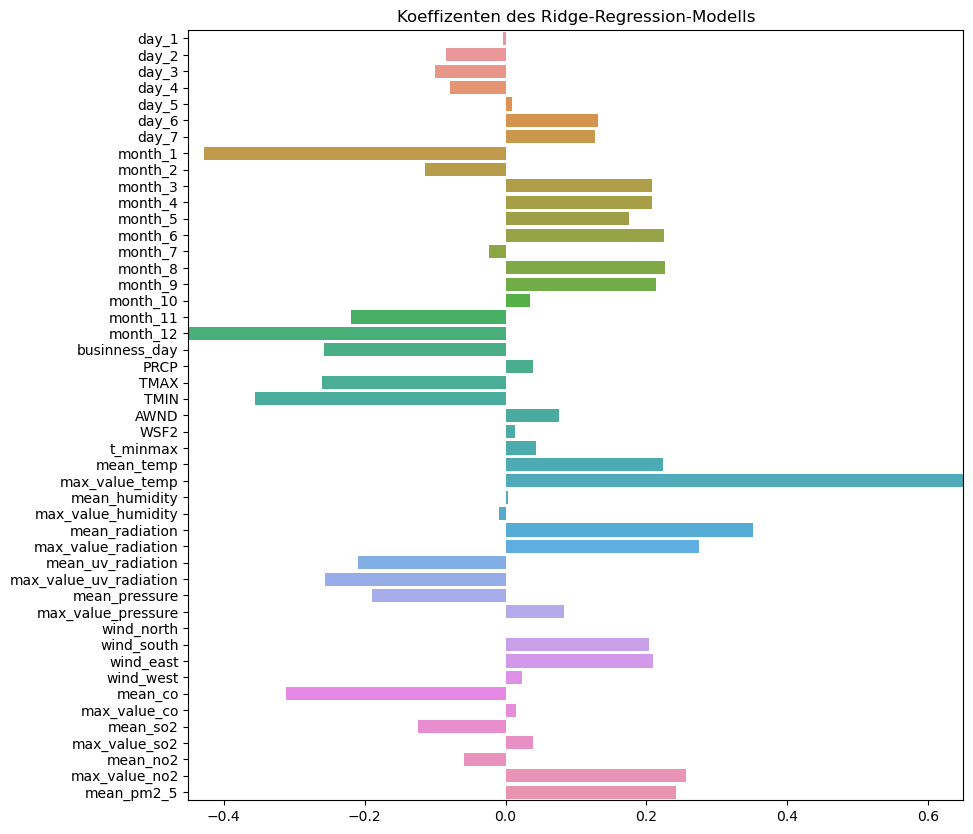

In [8]:
#anderes lineares Modell -> linear Ridge

ridge_reg=Ridge()
ridge_reg.fit(X_train,y_train)
score= ridge_reg.score(X_test,y_test)
print(f"Score of the model: {score}")

fig_coef, ax_coef = plt.subplots(1,1,figsize=(10,10))
ax_coef = sns.barplot(y=X_train.columns,x=ridge_reg.coef_,orient="h")
ax_coef.set_xlim(-0.45,0.65)
ax_coef.set_title("Koeffizenten des Ridge-Regression-Modells")


R2: 0.6563675817119009


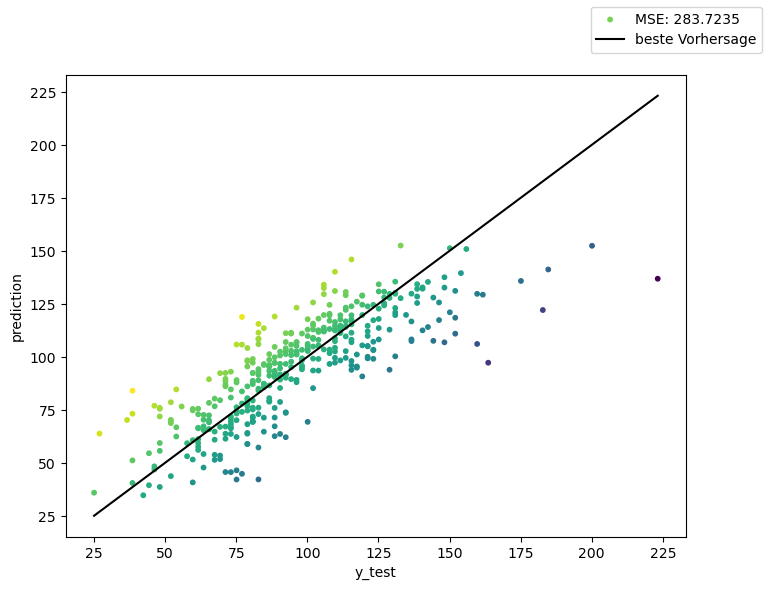

In [9]:
ridge_fig, ridge_ax= plt.subplots(1,1,figsize=(8,6))

st_scaler_attributes=pd.DataFrame(data={"mean":st_scaler.mean_,"var":np.sqrt(st_scaler.var_)},index=col_to_scale)
#Formula for reverse st_scaling x= z*s + u
y_true= y_test * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
y_predict = ridge_reg.predict(X_test) * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
error = y_predict-y_true
mse=mean_squared_error(y_true=y_true,y_pred=y_predict)
ridge_ax.scatter(y_true,y_predict,s=10,c=error,cmap="viridis",label=f"MSE: {np.round(mse,4)}")
x=np.linspace(y_true.min(),y_true.max())
ridge_ax.plot(x,x,c="black",label="beste Vorhersage")
ridge_ax.set_xlabel("y_test")
ridge_ax.set_ylabel("prediction")
ridge_fig.legend()
print(f"R2: {metrics.r2_score(y_true,y_predict)}")

Insgesamt ist das lineare Fitting nicht geeignet, da Underfitting zu beobachten ist. Im oben gezeigten Bild wäre eine Funtion mit mehr Freiheitsgeraden (z.B. mit x²-Term) bessere geeignet. 

### RandomForest Regressor

In [10]:
rfr=ensemble.RandomForestRegressor(random_state=1)
rfr_params={
    "criterion":["squared_error"],
    "n_estimators":[120],#120 
    "max_depth":[15], #15 is the best
    }

rfr_o3_search=model_selection.GridSearchCV(estimator=rfr,param_grid=rfr_params,scoring=["neg_mean_squared_error","explained_variance","r2"],refit="neg_mean_squared_error",
                                       verbose=2,n_jobs=4,cv=5)
rfr_o3_search.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END criterion=squared_error, max_depth=15, n_estimators=120; total time=   2.9s
[CV] END criterion=squared_error, max_depth=15, n_estimators=120; total time=   5.6s
[CV] END criterion=squared_error, max_depth=15, n_estimators=120; total time=   4.5s
[CV] END criterion=squared_error, max_depth=15, n_estimators=120; total time=   5.8s
[CV] END criterion=squared_error, max_depth=15, n_estimators=120; total time=   3.9s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=4,
             param_grid={'criterion': ['squared_error'], 'max_depth': [15],
                         'n_estimators': [120]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'explained_variance', 'r2'],
             verbose=2)

{'criterion': 'squared_error', 'max_depth': 15, 'n_estimators': 120}
Score on the test Data
R2: 0.7293480224689202


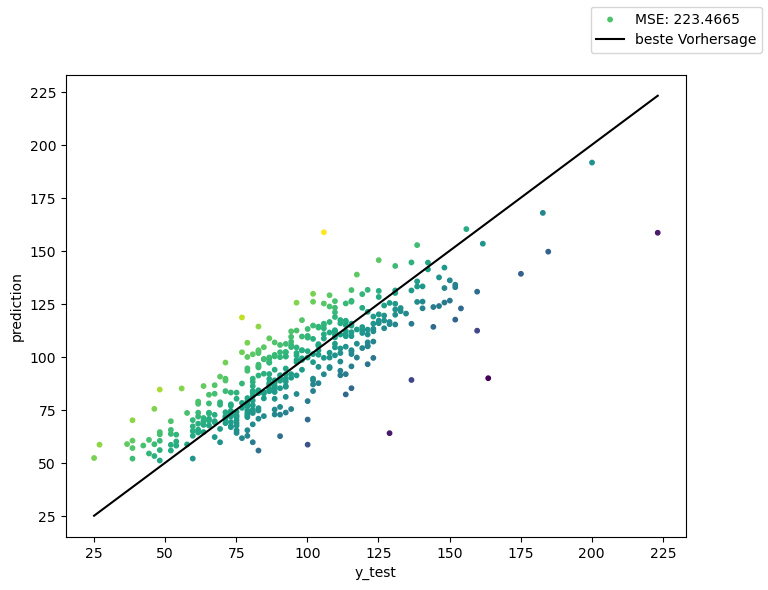

In [11]:
print(rfr_o3_search.best_params_)
rfr_fig, rfr_ax= plt.subplots(1,1,figsize=(8,6))
model=rfr_o3_search.best_estimator_

st_scaler_attributes=pd.DataFrame(data={"mean":st_scaler.mean_,"var":np.sqrt(st_scaler.var_)},index=col_to_scale)
#Formula for reverse st_scaling x= z*s + u
y_true= y_test * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
y_predict = model.predict(X_test) * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
error = y_predict-y_true
mse=mean_squared_error(y_true=y_true,y_pred=y_predict)
rfr_ax.scatter(y_true,y_predict,s=10,c=error,cmap="viridis",label=f"MSE: {np.round(mse,4)}")
x=np.linspace(y_true.min(),y_true.max())
rfr_ax.plot(x,x,c="black",label="beste Vorhersage")
rfr_ax.set_xlabel("y_test")
rfr_ax.set_ylabel("prediction")
rfr_fig.legend()
print("Score on the test Data")
print(f"R2: {metrics.r2_score(y_true,y_predict)}")

### Gradient Boosting Regression

In [12]:
gbr=ensemble.GradientBoostingRegressor(random_state=1)
gbr_params={
    "loss":["squared_error"],
    "n_estimators":[150],#150 
    "max_depth":[3], #3 is the best
    "learning_rate":[0.1,] #0.1 is the best
    }

gbr_o3_search=model_selection.GridSearchCV(estimator=gbr,param_grid=gbr_params,scoring=["neg_mean_squared_error","explained_variance","r2"],refit="neg_mean_squared_error",
                                       verbose=2,n_jobs=4,cv=5)
gbr_o3_search.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.1, loss=squared_error, max_depth=3, n_estimators=150; total time=   1.3s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=3, n_estimators=150; total time=   1.5s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=3, n_estimators=150; total time=   1.6s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=3, n_estimators=150; total time=   1.8s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=3, n_estimators=150; total time=   1.3s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1),
             n_jobs=4,
             param_grid={'learning_rate': [0.1], 'loss': ['squared_error'],
                         'max_depth': [3], 'n_estimators': [150]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'explained_variance', 'r2'],
             verbose=2)

{'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'n_estimators': 150}
Score on the test Data
R2: 0.7450464151892842


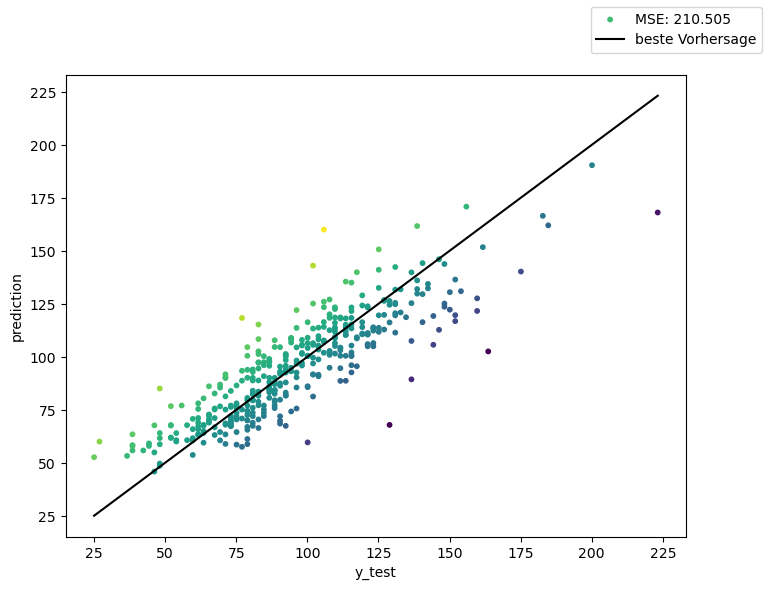

In [13]:
print(gbr_o3_search.best_params_)
gbr_fig, gbr_ax= plt.subplots(1,1,figsize=(8,6))
model=gbr_o3_search.best_estimator_

st_scaler_attributes=pd.DataFrame(data={"mean":st_scaler.mean_,"var":np.sqrt(st_scaler.var_)},index=col_to_scale)
#Formula for reverse st_scaling x= z*s + u
y_true= y_test * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
y_predict = model.predict(X_test) * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
error = y_predict-y_true
mse=mean_squared_error(y_true=y_true,y_pred=y_predict)
gbr_ax.scatter(y_true,y_predict,s=10,c=error,cmap="viridis",label=f"MSE: {np.round(mse,4)}")
x=np.linspace(y_true.min(),y_true.max())
gbr_ax.plot(x,x,c="black",label="beste Vorhersage")
gbr_ax.set_xlabel("y_test")
gbr_ax.set_ylabel("prediction")
gbr_fig.legend()
print("Score on the test Data")
print(f"R2: {metrics.r2_score(y_true,y_predict)}")

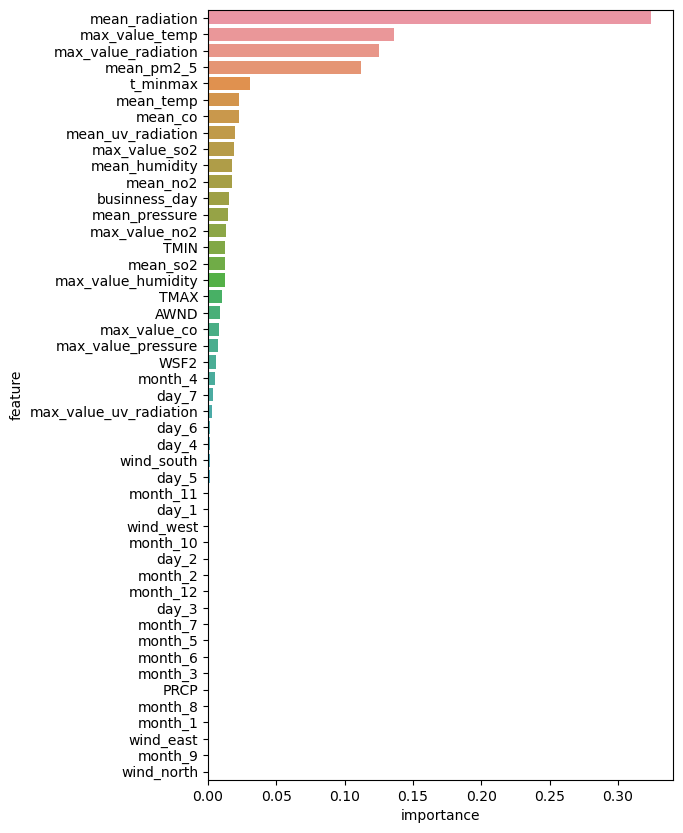

In [16]:
gbr_data=pd.DataFrame(data={"importance":rfr_o3_search.best_estimator_.feature_importances_,"feature":rfr_o3_search.best_estimator_.feature_names_in_})
gbr_data=gbr_data.sort_values("importance",ascending=False)
fig,ax=plt.subplots(1,1,figsize=(6,10))
ax=sns.barplot(x=gbr_data["importance"],y=gbr_data.feature,orient="h")

### Übersicht über die Modelle

| Modell                    | R²     | MSE    |
|---------------------------|--------|--------|
| OLS                       | 0.7072 | 267.24 |
| Ridge                     | 0.7089 | 265.70 |
| RandomForest Regression   | 0.7676 | 212.13 |
| GradientBoostingRegressor | 0.7680 | 211.77 |

- deutlich mehr Freiheitsgerade im Modell verbessern die Vorhersage
- möglicherweiße stimmen die Werte hier nicht ganz genau überein mit den tatsächlichen Werten


## Supervised Clustering with AQI O3
**Clustering bessere Wahl als Vorhersage des genauen Wertes**   
Clustering ist die bessere Wahl da die genaue Konzentration an Schadstoff für die Bevölkerung nicht so relevant sein dürfte. Viel wichtiger ist die Einteilung in die verschiedenen Kategorien mit den daraus resultierenden Gesundheitsgefahren bzw. Verhaltensanweisungen.    
Datengrundlage: Daten von oben inkl. der Schadstoffmesswerte (außer O3)

### Vorgehensweise für neue ML-Modelle
Nachfolgend soll immer ähnlich vorgegangen werden: 
1. Die richtigen Daten sollen ausgewählt und evtl. vorbehandelt (z.B. Standartisierung) werden. 
2. Aufteilen der Daten in train + test
3. Erstellen des Modells und des GridSearchCV Objekts, dieses sucht anschließend nach den besten Hyperparametern des Modells
4. Evaluation des Modells mit einer Confusion Matrix (Vierfeldertafel für den nichbinären Fall), f1_score, score und balanced_score
5. Optional: Wo möglich sollen die für das Modell wichtigsten Features angezeigt werden -> besser Erklärbarkeit des Modells

In [14]:
predict_column="aqi_o3"
X_train_classify , X_test_classify , y_train_classify , y_test_classify = train_test_split(predict_today_dropna.drop(['aqi_pm2_5','aqi_so2',
                                                                           'aqi_no2',predict_column,"mean_o3","max_value_o3","aqi_max"],axis=1),
                                                       predict_today_dropna[predict_column],random_state=1)
X_train_classify

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,month_1,month_2,month_3,...,wind_south,wind_east,wind_west,mean_co,max_value_co,mean_so2,max_value_so2,mean_no2,max_value_no2,mean_pm2_5
2018-08-13,1,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,-0.719147,-0.377507,0.490156,-0.179585,-0.909257,-0.937663,-0.211271
2015-04-01,0,0,1,0,0,0,0,0,0,0,...,1.0,0.0,0.0,-0.978981,-0.365470,-0.845292,-0.317517,-0.357295,0.003746,0.107401
2016-06-13,1,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,-1.155951,-1.342603,-0.696909,-0.005671,-1.259983,-1.499131,-0.742391
2016-04-26,0,1,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,-0.794099,-1.101437,-0.845292,-0.053647,-0.679273,-0.984100,-0.302320
2017-02-09,0,0,0,1,0,0,0,0,1,0,...,1.0,0.0,0.0,1.407414,0.828972,0.341773,-0.191579,-0.138810,0.248597,-0.408544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-03,0,0,1,0,0,0,0,0,0,0,...,1.0,0.0,0.0,-0.644611,-0.618673,-0.696909,-0.023662,-0.524034,-0.017361,0.077051
2017-11-23,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,1.0,0.821537,1.070353,1.083689,0.036309,0.453399,0.214825,-0.681692
2018-06-20,0,0,1,0,0,0,0,0,0,0,...,0.0,1.0,0.0,-0.505533,-0.618673,1.973987,-0.131609,-0.409042,-0.747692,0.866144
2015-11-02,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,-0.152425,0.346423,-1.142058,-0.317517,-0.311298,-0.182003,-0.590643


In [15]:
'Train the model'
rfc = RandomForestClassifier(max_depth=200,min_samples_split=10)
rfc.fit(X_train_classify,y_train_classify)
score= rfc.score(X_test_classify,y_test_classify)
print(f"Score of the model: {score}")


Score of the model: 0.7375


balanced score of the model: 0.5073742047426257
f1 score of the model: 0.7202209962752224
Test Score of the Models
score of the model: 0.7375
balanced score of the model: 0.50737
f1 score of the model: 0.72022


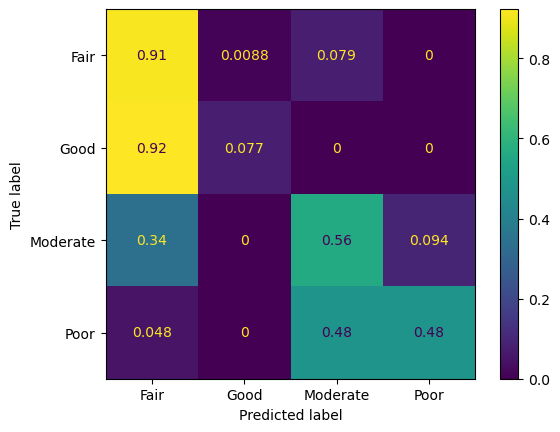

In [16]:
'Evaluate the model'
model=rfc
y_predict=model.predict(X_test_classify)
score_balanced= balanced_accuracy_score(y_true=y_test_classify,y_pred=y_predict)
print(f"balanced score of the model: {score_balanced}")
f1_score= metrics.f1_score(y_true=y_test_classify,y_pred=y_predict,average="weighted")
print(f"f1 score of the model: {f1_score}")

'Test Score'
print("Test Score of the Models")
accuracy_test=metrics.accuracy_score(y_test_classify,y_predict)
print(f"score of the model: {round(accuracy_test,5)}")
balanced_accuracy_test=metrics.balanced_accuracy_score(y_test_classify,y_predict)
print(f"balanced score of the model: {round(balanced_accuracy_test,5)}")
f1_test=metrics.f1_score(y_test_classify,y_predict,average="weighted")
print(f"f1 score of the model: {round(f1_test,5)}")

cm=confusion_matrix(y_true=y_test_classify,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

Das Modell scheint besonders häufig sich einfach nur für Fair zu entscheiden, was in den Daten am häufigsten vorkommt (siehe nächster Output)

In [17]:
'Häufigkeit der Labels in y_train'
y_train_classify.value_counts()

Fair              663
Moderate          346
Poor              147
Good               43
Very Poor           0
Extremely Poor      0
Name: aqi_o3, dtype: int64

### Klassifikation mit KNN
hier wird KNN ohne vorherige Reduktion der Dimension durchgeführt

In [18]:
knn_solo=neighbors.KNeighborsClassifier()
param={
    'n_neighbors': [2, 4, 6, 8],
    'weights': ['uniform', 'distance'],
    "metric" : ["cityblock","l2","cosine"]
    }
knn_search= model_selection.GridSearchCV(knn_solo,param,n_jobs=4,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted")
knn_search.fit(X_train_classify,y_train_classify)
knn_search_result=pd.DataFrame(knn_search.cv_results_)


 balanced score of the model: 0.5388122206839163
f1-Score: 0.6989937889517159
Test Score of the Models
score of the model: 0.7125
balanced score of the model: 0.50944
f1 score of the model: 0.70081


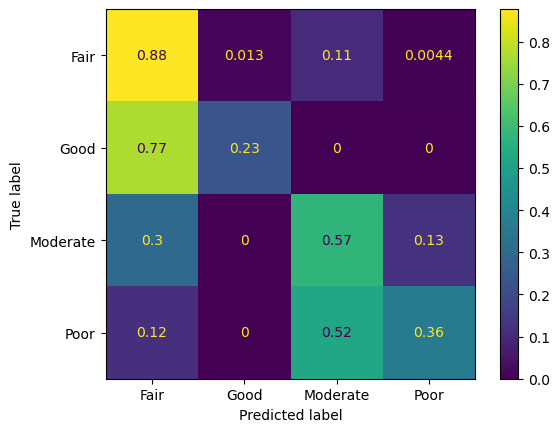

In [19]:
model=knn_search
y_predict=model.predict(X_test_classify)
score_balanced= knn_search_result.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f" balanced score of the model: {score_balanced}")
f1=knn_search_result.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {f1}")

'Test Score'
print("Test Score of the Models")
accuracy_test=metrics.accuracy_score(y_test_classify,y_predict)
print(f"score of the model: {round(accuracy_test,5)}")
balanced_accuracy_test=metrics.balanced_accuracy_score(y_test_classify,y_predict)
print(f"balanced score of the model: {round(balanced_accuracy_test,5)}")
f1_test=metrics.f1_score(y_test_classify,y_predict,average="weighted")
print(f"f1 score of the model: {round(f1_test,5)}")

cm=confusion_matrix(y_true=y_test_classify,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

Das KNN-Modell zeigt recht ähnliche Ergebnisse wie das RandomForest Modell oben.

### Pipeline mit PCA + KNN
üblicherweiße wird vor dem Clustern in großen Dimensionen eine Dimensionreduktion durchgeführt.
- Grund: Die meisten Features korrelieren miteinander -> beschreibung der Daten mit den sogenannten Hauptachsen (zeigen in Richtung der größten Varianz)
- Vorteile: Clustern ist schneller, Resistenter gegen Rauschen, ...

Text(0, 0.5, 'erklärte Varianz')

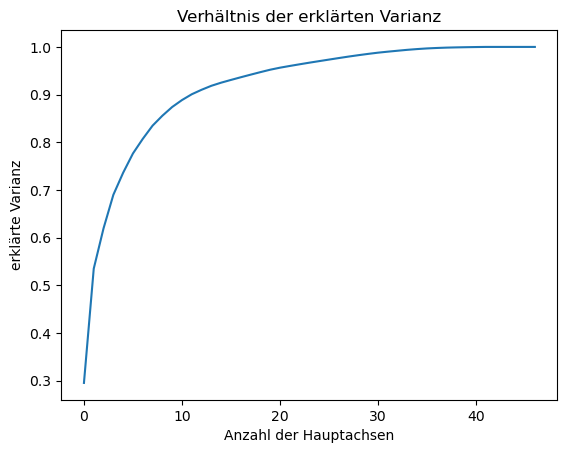

In [20]:
'erstes testen der PCA'
pca=decomposition.PCA()
'Important: only fit train data'
pca.fit(X_train_classify)

X_train_classify_pca=pca.transform(X_train_classify)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Verhältnis der erklärten Varianz")
plt.xlabel("Anzahl der Hauptachsen")
plt.ylabel("erklärte Varianz")


Es wird meist erwartet das sich die Daten mit einigen wenigen Achsen gut beschreiben lassen --> hier nicht der Fall  
Da unklar ist wieviel Achsen am besten sind: Gridsearch mit PCA und KNN -> dafür wird eine Pipeline erstellt wie im [Beispiel](https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html) hier 
- Welche Metric ist die beste für Classifizierung ? [Medium Artikel](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226)
- f1 scheint hierbei die beste Wahl zu sein, da sowohl Precision (Genauigkeit) und Recall (Sensitivität, Wahrscheinlichkeit das z.B. positiver Fall auch gefunden wird) berücksichtigt werden

In [21]:
pca_pipeline=decomposition.PCA()
knn_pipeline=neighbors.KNeighborsClassifier()

pipe=Pipeline(steps=[("pca",pca_pipeline),("knn",knn_pipeline)])
param={
    "pca__n_components": [8,11], #11
    'knn__n_neighbors': [ 8], #8
    'knn__weights': [ 'distance'], #distance
    "knn__metric" : ["cosine"] #cosine
    }
pca_knn_search= model_selection.GridSearchCV(pipe,param,n_jobs=4,verbose=2,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted")
pca_knn_search.fit(X_train_classify,y_train_classify)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END knn__metric=cosine, knn__n_neighbors=8, knn__weights=distance, pca__n_components=8; total time=   0.1s
[CV] END knn__metric=cosine, knn__n_neighbors=8, knn__weights=distance, pca__n_components=8; total time=   0.1s
[CV] END knn__metric=cosine, knn__n_neighbors=8, knn__weights=distance, pca__n_components=8; total time=   0.1s
[CV] END knn__metric=cosine, knn__n_neighbors=8, knn__weights=distance, pca__n_components=8; total time=   0.2s
[CV] END knn__metric=cosine, knn__n_neighbors=8, knn__weights=distance, pca__n_components=8; total time=   0.3s
[CV] END knn__metric=cosine, knn__n_neighbors=8, knn__weights=distance, pca__n_components=11; total time=   0.1s
[CV] END knn__metric=cosine, knn__n_neighbors=8, knn__weights=distance, pca__n_components=11; total time=   0.2s
[CV] END knn__metric=cosine, knn__n_neighbors=8, knn__weights=distance, pca__n_components=11; total time=   0.1s
[CV] END knn__metric=cosine, knn__n_neigh

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=4,
             param_grid={'knn__metric': ['cosine'], 'knn__n_neighbors': [8],
                         'knn__weights': ['distance'],
                         'pca__n_components': [8, 11]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'],
             verbose=2)

The best parameters of the model are:
{'knn__metric': 'cosine', 'knn__n_neighbors': 8, 'knn__weights': 'distance', 'pca__n_components': 11}
score of the model: 0.70306
balanced score of the model: 0.51581
f1-Score: 0.69899
Test Score of the Models
score of the model: 0.695
balanced score of the model: 0.49751
f1 score of the model: 0.68226


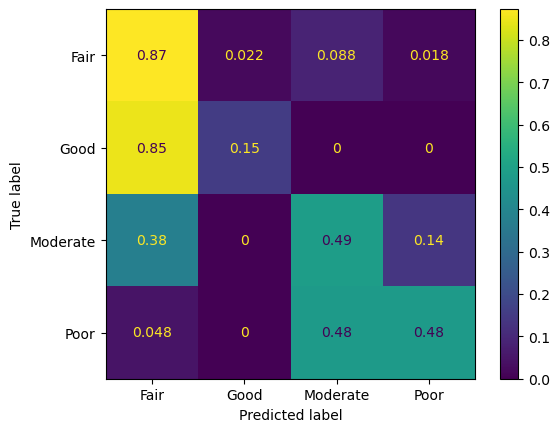

In [22]:
'Choose your model with tuned parameter with GridSearchCV'
model=pca_knn_search

model_search_results=pd.DataFrame(model.cv_results_)
y_predict=model.predict(X_test_classify)

print("The best parameters of the model are:")
print(model.best_params_,end="\n")
'Print the scores'
score= model_search_results.sort_values("rank_test_accuracy")["mean_test_accuracy"].iloc[0]
print(f"score of the model: {round(score,5)}")
score_balanced= model_search_results.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f"balanced score of the model: {round(score_balanced,5)}")
score_f1=model_search_results.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {round(f1,5)}")

'Test Score'
print("Test Score of the Models")
accuracy_test=metrics.accuracy_score(y_test_classify,y_predict)
print(f"score of the model: {round(accuracy_test,5)}")
balanced_accuracy_test=metrics.balanced_accuracy_score(y_test_classify,y_predict)
print(f"balanced score of the model: {round(balanced_accuracy_test,5)}")
f1_test=metrics.f1_score(y_test_classify,y_predict,average="weighted")
print(f"f1 score of the model: {round(f1_test,5)}")

cm=confusion_matrix(y_true=y_test_classify,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

Durch die PCA vorher hat sich das Modell nicht verbessert, sondern leicht verschlechtert.
Mögliche Erklärungen:  
- binäre Spalten sind für PCA nicht geeignet ?
- zu wenige Daten
- supervised Clustering im allgemeinen nicht geeignet

### Gradient Boosting Classifier 
Ensemble Methode wie Random Forest, das auf mehreren Decision Trees (schwache Lerner) aufbaut -> der nächste Baum ist immer auf den Fehler des letzten fokussiert.


In [23]:
gbc=ensemble.GradientBoostingClassifier(random_state=1)
gbc_params={
    "gbc__loss":["log_loss"],
    "gbc__n_estimators":[135], #135
    "gbc__max_depth":[3], #3 is the best
    "gbc__learning_rate":[0.095] #0.095 is the best
    }

pipeline_aqio3=Pipeline([("scaler",StandardScaler()),("gbc",gbc)])
gbc_seach=model_selection.GridSearchCV(estimator=pipeline_aqio3,param_grid=gbc_params,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted",
                                       verbose=2,n_jobs=4,cv=10)
gbc_seach.fit(X_train_classify,y_train_classify)


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END gbc__learning_rate=0.095, gbc__loss=log_loss, gbc__max_depth=3, gbc__n_estimators=135; total time=   9.5s
[CV] END gbc__learning_rate=0.095, gbc__loss=log_loss, gbc__max_depth=3, gbc__n_estimators=135; total time=  10.2s
[CV] END gbc__learning_rate=0.095, gbc__loss=log_loss, gbc__max_depth=3, gbc__n_estimators=135; total time=  11.5s
[CV] END gbc__learning_rate=0.095, gbc__loss=log_loss, gbc__max_depth=3, gbc__n_estimators=135; total time=  13.3s
[CV] END gbc__learning_rate=0.095, gbc__loss=log_loss, gbc__max_depth=3, gbc__n_estimators=135; total time=  10.6s
[CV] END gbc__learning_rate=0.095, gbc__loss=log_loss, gbc__max_depth=3, gbc__n_estimators=135; total time=  13.4s
[CV] END gbc__learning_rate=0.095, gbc__loss=log_loss, gbc__max_depth=3, gbc__n_estimators=135; total time=  11.4s
[CV] END gbc__learning_rate=0.095, gbc__loss=log_loss, gbc__max_depth=3, gbc__n_estimators=135; total time=  13.6s
[CV] END gbc__learn

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gbc',
                                        GradientBoostingClassifier(random_state=1))]),
             n_jobs=4,
             param_grid={'gbc__learning_rate': [0.095],
                         'gbc__loss': ['log_loss'], 'gbc__max_depth': [3],
                         'gbc__n_estimators': [135]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'],
             verbose=2)

The best parameters of the model are:
{'gbc__learning_rate': 0.095, 'gbc__loss': 'log_loss', 'gbc__max_depth': 3, 'gbc__n_estimators': 135}
score of the model: 0.72475
balanced score of the model: 0.56732
f1-Score: 0.69899


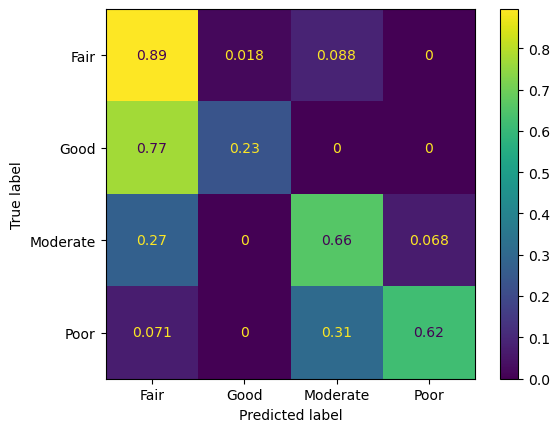

In [24]:
'Choose your model with tuned parameter with GridSearchCV'
model=gbc_seach

model_search_results=pd.DataFrame(model.cv_results_)
y_predict=model.predict(X_test_classify)

print("The best parameters of the model are:")
print(model.best_params_,end="\n")
'Print the scores'
score= model_search_results.sort_values("rank_test_accuracy")["mean_test_accuracy"].iloc[0]
print(f"score of the model: {round(score,5)}")
score_balanced= model_search_results.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f"balanced score of the model: {round(score_balanced,5)}")
score_f1=model_search_results.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {round(f1,5)}")

cm=confusion_matrix(y_true=y_test_classify,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

Das GBC-Modell zeigt eine bessere Vorhersage bei den Moderate and Poor AQI Werten. Demnach ist es das bisher beste Modell.

In [25]:
gbc_seach.best_estimator_["gbc"]

GradientBoostingClassifier(learning_rate=0.095, n_estimators=135,
                           random_state=1)

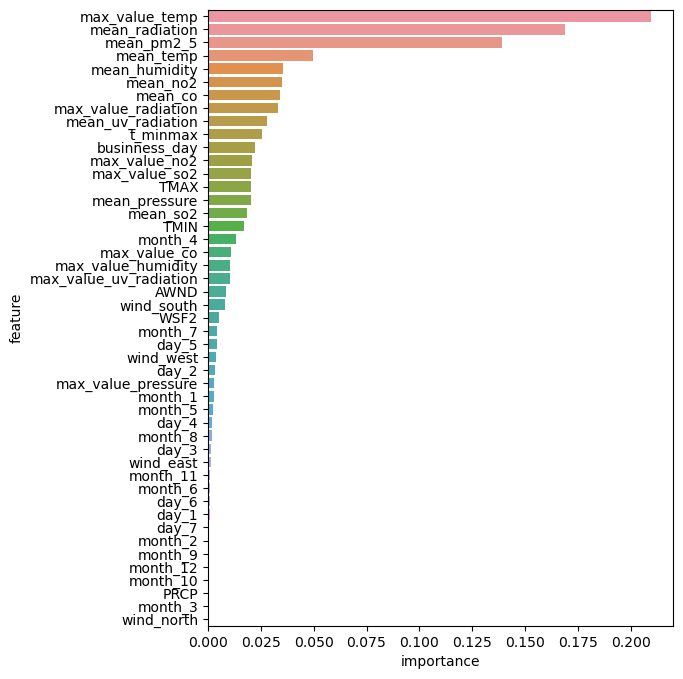

In [26]:
"Which features are the most important in the model"
gbc_data=pd.DataFrame(data={"importance":gbc_seach.best_estimator_["gbc"].feature_importances_,"feature":gbc_seach.best_estimator_.feature_names_in_})
gbc_data=gbc_data.sort_values("importance",ascending=False)
fig,ax=plt.subplots(1,1,figsize=(6,8))
ax=sns.barplot(x=gbc_data["importance"],y=gbc_data.feature,orient="h")


Wie für Ozon zu erwarten ist eine hohe Temperatur und hohe Strahlung für die radikalische Entstehung entscheident.

## Vorhersage des AQI_NO2
Da die Strahlung und der Druck für NO2 keine so wichtige Rolle spielen (vgl. Explorative Datenanalyse) kann auf diese Features verzichtet werden. Der Vorteil ist dabei, dass nach dem Bereinigen von Tagen mit fehlenden Werten mehr Tage übrig bleiben. 

In [27]:
predict_no2=predict_today.drop(["mean_radiation" , "max_value_radiation", "mean_uv_radiation" 
                                , "max_value_uv_radiation", "mean_pressure","max_value_pressure"],axis=1)
predict_no2.dropna(inplace=True)
predict_no2.shape

(5174, 48)

In [28]:
predict_column="aqi_no2"
X_train_aqino2 , X_test_aqino2 , y_train_aqino2 , y_test_aqino2 = train_test_split(predict_no2.drop(["aqi_max","aqi_no2","aqi_o3","aqi_pm2_5","aqi_so2",predict_column,"max_value_no2","mean_no2"],axis=1),
                                                       predict_no2[predict_column],random_state=1)
X_train_aqino2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3880 entries, 2007-10-28 to 2019-12-13
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   day_1               3880 non-null   uint8  
 1   day_2               3880 non-null   uint8  
 2   day_3               3880 non-null   uint8  
 3   day_4               3880 non-null   uint8  
 4   day_5               3880 non-null   uint8  
 5   day_6               3880 non-null   uint8  
 6   day_7               3880 non-null   uint8  
 7   month_1             3880 non-null   uint8  
 8   month_2             3880 non-null   uint8  
 9   month_3             3880 non-null   uint8  
 10  month_4             3880 non-null   uint8  
 11  month_5             3880 non-null   uint8  
 12  month_6             3880 non-null   uint8  
 13  month_7             3880 non-null   uint8  
 14  month_8             3880 non-null   uint8  
 15  month_9             3880 non-null   u

### GBC
Dazu wird erneut der GradientBoostClassifier verwendet

In [29]:
gbc=ensemble.GradientBoostingClassifier(random_state=1)
gbc_params={
    "loss":["log_loss"],
    "n_estimators":[145],#145
    "max_depth":[5], #5 is the best
    "learning_rate":[0.109] #0.109 is the best
    }

gbc_no2_search=model_selection.GridSearchCV(estimator=gbc,param_grid=gbc_params,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted",
                                       verbose=2,n_jobs=4,cv=5)
gbc_no2_search.fit(X_train_aqino2,y_train_aqino2)


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END learning_rate=0.109, loss=log_loss, max_depth=5, n_estimators=145; total time=  45.6s
[CV] END learning_rate=0.109, loss=log_loss, max_depth=5, n_estimators=145; total time=  52.0s
[CV] END learning_rate=0.109, loss=log_loss, max_depth=5, n_estimators=145; total time=  55.0s
[CV] END learning_rate=0.109, loss=log_loss, max_depth=5, n_estimators=145; total time=  57.9s
[CV] END learning_rate=0.109, loss=log_loss, max_depth=5, n_estimators=145; total time=  39.4s
[CV] END learning_rate=0.109, loss=log_loss, max_depth=5, n_estimators=145; total time=  48.2s
[CV] END learning_rate=0.109, loss=log_loss, max_depth=5, n_estimators=145; total time=  39.2s
[CV] END learning_rate=0.109, loss=log_loss, max_depth=5, n_estimators=145; total time=  41.6s
[CV] END learning_rate=0.109, loss=log_loss, max_depth=5, n_estimators=145; total time=  33.6s
[CV] END learning_rate=0.109, loss=log_loss, max_depth=5, n_estimators=145; total ti

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=1),
             n_jobs=4,
             param_grid={'learning_rate': [0.109], 'loss': ['log_loss'],
                         'max_depth': [5], 'n_estimators': [145]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'],
             verbose=2)

The best parameters of the model are:
{'learning_rate': 0.109, 'loss': 'log_loss', 'max_depth': 5, 'n_estimators': 145}
score of the model: 0.77732
balanced score of the model: 0.5894
f1-Score: 0.77324


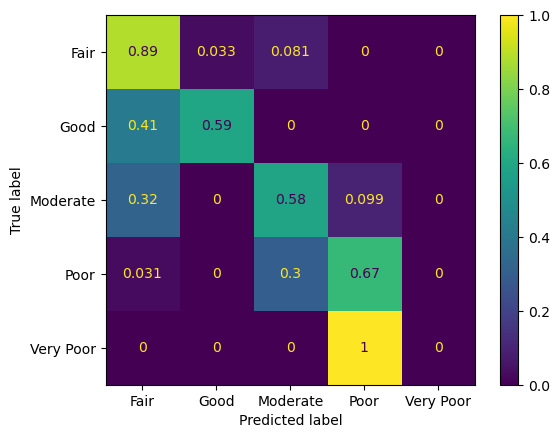

In [30]:
'Choose your model with tuned parameter with GridSearchCV'
model=gbc_no2_search

model_search_results=pd.DataFrame(model.cv_results_)
y_predict=model.predict(X_test_aqino2)

print("The best parameters of the model are:")
print(model.best_params_,end="\n")
'Print the scores'
score= model_search_results.sort_values("rank_test_accuracy")["mean_test_accuracy"].iloc[0]
print(f"score of the model: {round(score,5)}")
score_balanced= model_search_results.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f"balanced score of the model: {round(score_balanced,5)}")
score_f1=model_search_results.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {round(score_f1,5)}")

cm=confusion_matrix(y_true=y_test_aqino2,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

Die Vorhersage klappt hierbei deutlich besser im Vergleich zu Ozon. Jedoch ist die Vorhersage bei Very Poor komplett falsch, dies liegt jedoch auch daran das nur 6 Tage diesen AQI Index haben (vgl. Output unten). Eigentlich sollte dieser Wert daher entfernt werden. 

In [31]:
y_test_aqino2.value_counts()

Fair              781
Moderate          284
Poor              131
Good               92
Very Poor           6
Extremely Poor      0
Name: aqi_no2, dtype: int64

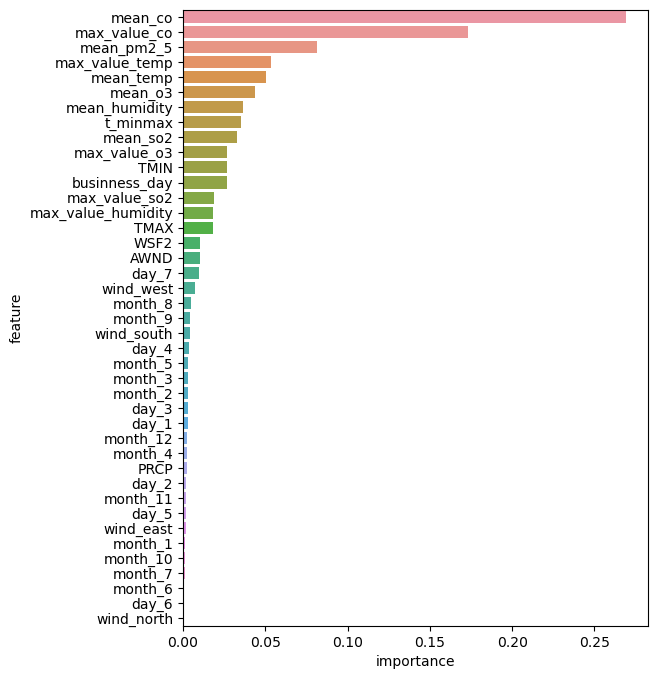

In [32]:
"Which features are the most important in the model"
gbc_data=pd.DataFrame(data={"importance":gbc_no2_search.best_estimator_.feature_importances_,"feature":gbc_no2_search.best_estimator_.feature_names_in_})
gbc_data=gbc_data.sort_values("importance",ascending=False)
fig,ax=plt.subplots(1,1,figsize=(6,8))
ax=sns.barplot(x=gbc_data["importance"],y=gbc_data.feature,orient="h")

Wenig überraschend ist hier CO ein sehr wichtiges Feature, da dies ebenfalls durch die gemeinsame Quelle den Verkehr verursacht wird. 
Da mit diesen Daten eine gute Vorhersage möglich war und es deutlich mehr Daten gibt, werden diese auch für das neuronale Netz verwendet.

In [33]:
'Save this data for the neural network'
predict_no2.to_hdf("Predictor_Data/neural_network_data.h5",key="data",format="table")

## Vorhersage des max AQI Index
### verbessert sich die Performance mit mehr Features? 
- dazu werden aus den Modellen oben einige wichtige Features ausgesucht und ergänzt. Dabei werden jedoch immer nur die Werte von einem Tag/zwei tage vorher verwendet. 
- Features die auf diesem Weg hinzugefügt werden: 
  * max_value_temp
  * mean_radiation
  * mean_temp
  * t_minmax
  * mean_pressure
  * mean_co
  * max_value_co
  * max_value_radiation
  * mean_wind_speed

In [34]:
'hinzufügen der neuen Features'
columns_highly_relevant=["max_value_temp","mean_radiation","mean_temp","t_minmax","mean_pressure","mean_co","max_value_co","max_value_radiation",'mean_pm2_5','max_value_no2']
predict_nafilled_morefeatures=predict_today_dropna
#increase datetime index by one day
for today in [-1,-2]:
    df_relevant=predict_today_dropna[columns_highly_relevant]
    df_relevant.index=df_relevant.index+ datetime.timedelta(days=-today)
    df_relevant.columns = [f"{old_col}_today{today}" for old_col in df_relevant.columns]
    predict_nafilled_morefeatures=predict_nafilled_morefeatures.join(df_relevant)
print(f"Shape: {predict_nafilled_morefeatures.shape}")
predict_nafilled_morefeatures.dropna(axis=0,inplace=True)
print(f"Shape after dropna: {predict_nafilled_morefeatures.shape}")

Shape: (1599, 74)
Shape after dropna: (1396, 74)


In [35]:
'Split in train and test data'
predict_column="aqi_max"
#standart features
X_train_aqimax , X_test_aqimax , y_train_aqimax , y_test_aqimax = train_test_split(predict_nafilled_morefeatures.drop(["aqi_max","aqi_no2","aqi_o3","aqi_pm2_5",
                                                                                                                       "aqi_so2",predict_column,"max_value_o3","mean_o3",
                                                                                                                       'mean_so2', 'max_value_so2', 'mean_no2','max_value_no2', 'mean_pm2_5'],axis=1),
                                                       predict_nafilled_morefeatures[predict_column],random_state=1)
X_test_aqimax.columns

Index(['day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'businness_day', 'PRCP', 'TMAX', 'TMIN', 'AWND', 'WSF2', 't_minmax',
       'mean_temp', 'max_value_temp', 'mean_humidity', 'max_value_humidity',
       'mean_radiation', 'max_value_radiation', 'mean_uv_radiation',
       'max_value_uv_radiation', 'mean_pressure', 'max_value_pressure',
       'wind_north', 'wind_south', 'wind_east', 'wind_west', 'mean_co',
       'max_value_co', 'max_value_temp_today-1', 'mean_radiation_today-1',
       'mean_temp_today-1', 't_minmax_today-1', 'mean_pressure_today-1',
       'mean_co_today-1', 'max_value_co_today-1',
       'max_value_radiation_today-1', 'mean_pm2_5_today-1',
       'max_value_no2_today-1', 'max_value_temp_today-2',
       'mean_radiation_today-2', 'mean_temp_today-2', 't_minmax_today-2',
       'mean_pressure_tod

### GBC Modell

In [36]:
gbc=ensemble.GradientBoostingClassifier(random_state=1)
gbc_params={
    "loss":["log_loss"],
    "n_estimators":[150],#150
    "max_depth":[6], #6 is the best
    "learning_rate":[0.1] #0.1 is the best
    }

gbc_aqimax_search=model_selection.GridSearchCV(estimator=gbc,param_grid=gbc_params,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted",
                                       verbose=2,n_jobs=4,cv=4)
gbc_aqimax_search.fit(X_train_aqimax,y_train_aqimax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV] END learning_rate=0.1, loss=log_loss, max_depth=6, n_estimators=150; total time=  20.2s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=6, n_estimators=150; total time=  23.7s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=6, n_estimators=150; total time=  22.6s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=6, n_estimators=150; total time=  24.2s


GridSearchCV(cv=4, estimator=GradientBoostingClassifier(random_state=1),
             n_jobs=4,
             param_grid={'learning_rate': [0.1], 'loss': ['log_loss'],
                         'max_depth': [6], 'n_estimators': [150]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'],
             verbose=2)

The best parameters of the model are:
{'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 6, 'n_estimators': 150}
Training Score of the models
score of the model: 0.66761
balanced score of the model: 0.45442
f1-Score: 0.6652
Test Score of the Models
score of the model: 0.73926
balanced score of the model: 0.66446
f1 score of the model: 0.73371


/home/felix/anaconda3/envs/datascience_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


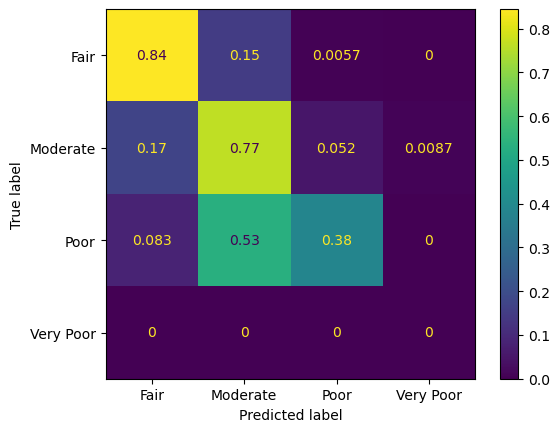

In [37]:
'Choose your model with tuned parameter with GridSearchCV'
model=gbc_aqimax_search

model_search_results=pd.DataFrame(model.cv_results_)
y_predict=model.predict(X_test_aqimax)

print("The best parameters of the model are:")
print(model.best_params_,end="\n")

'Training Score of the models'
print("Training Score of the models")
score= model_search_results.sort_values("rank_test_accuracy")["mean_test_accuracy"].iloc[0]
print(f"score of the model: {round(score,5)}")
score_balanced= model_search_results.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f"balanced score of the model: {round(score_balanced,5)}")
score_f1=model_search_results.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {round(score_f1,5)}",end="\n")

'Test Score'
print("Test Score of the Models")
accuracy_test=metrics.accuracy_score(y_test_aqimax,y_predict)
print(f"score of the model: {round(accuracy_test,5)}")
balanced_accuracy_test=metrics.balanced_accuracy_score(y_test_aqimax,y_predict)
print(f"balanced score of the model: {round(balanced_accuracy_test,5)}")
f1_test=metrics.f1_score(y_test_aqimax,y_predict,average="weighted")
print(f"f1 score of the model: {round(f1_test,5)}")

cm=confusion_matrix(y_true=y_test_aqimax,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

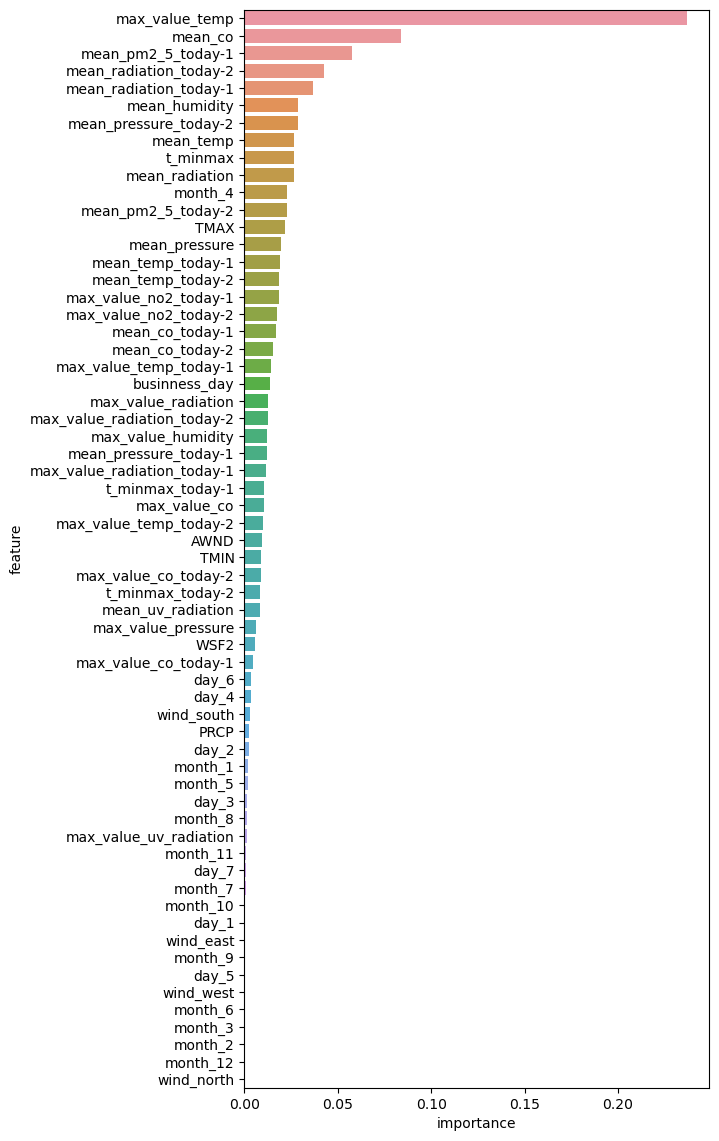

In [38]:
'Check the most important features'
gbc_data=pd.DataFrame(data={"importance":gbc_aqimax_search.best_estimator_.feature_importances_,"feature":gbc_aqimax_search.best_estimator_.feature_names_in_})
gbc_data=gbc_data.sort_values("importance",ascending=False)
fig,ax=plt.subplots(1,1,figsize=(6,14))
ax=sns.barplot(x=gbc_data["importance"],y=gbc_data.feature,orient="h")

Das Modell kann in diesem Fall ganz ordentlich die verschiedenen AQI Werte eines Tages vorhersagen. Schwierig könnte dabei insbesondere sein, dass die Ursache (also der Schadstoff) für den hohen AQI-Wert ganz verschieden sein kann, damit also auch die wichtigen Features.

### Adaboost
Testen eines weiteren Modells, welches recht ähnlich zu GBC ist.

In [39]:
adaboost=ensemble.AdaBoostClassifier()
adaboost_params={
    "base_estimator":[tree.DecisionTreeClassifier(criterion="gini",max_depth=3)],
    "n_estimators":[50,60], # 50 ist best
    "learning_rate":[0.1], #0.1 is the best
    }

adaboost_aqimax_search=model_selection.GridSearchCV(estimator=adaboost,param_grid=adaboost_params,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted",
                                       verbose=2,n_jobs=4,cv=5)
adaboost_aqimax_search.fit(X_train_aqimax,y_train_aqimax)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/felix/anaconda3/envs/datascience_env/lib/python3.10/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV] END base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.1, n_estimators=50; total time=   1.2s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.1, n_estimators=50; total time=   1.3s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.1, n_estimators=50; total time=   1.6s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.1, n_estimators=50; total time=   1.7s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.1, n_estimators=60; total time=   1.5s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.1, n_estimators=60; total time=   1.4s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.1, n_estimators=50; total time=   2.2s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.1, n_estimators=60; total time=   2.1s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3), learning_ra

GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=4,
             param_grid={'base_estimator': [DecisionTreeClassifier(max_depth=3)],
                         'learning_rate': [0.1], 'n_estimators': [50, 60]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'],
             verbose=2)

The best parameters of the model are:
{'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.1, 'n_estimators': 50}
Training Score of the models
score of the model: 0.58931
balanced score of the model: 0.43036
f1-Score: 0.58653
Test Score of the Models
score of the model: 0.63324
balanced score of the model: 0.55176
f1 score of the model: 0.61664


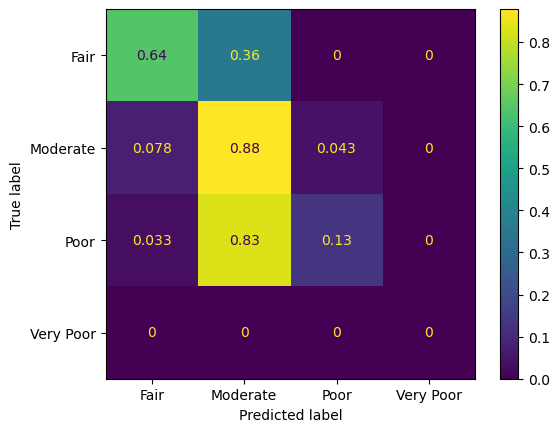

In [40]:
'Choose your model with tuned parameter with GridSearchCV'
model=adaboost_aqimax_search

model_search_results=pd.DataFrame(model.cv_results_)
y_predict=model.predict(X_test_aqimax)

print("The best parameters of the model are:")
print(model.best_params_,end="\n")

'Training Score of the models'
print("Training Score of the models")
score= model_search_results.sort_values("rank_test_accuracy")["mean_test_accuracy"].iloc[0]
print(f"score of the model: {round(score,5)}")
score_balanced= model_search_results.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f"balanced score of the model: {round(score_balanced,5)}")
score_f1=model_search_results.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {round(score_f1,5)}",end="\n")

'Test Score'
print("Test Score of the Models")
accuracy_test=metrics.accuracy_score(y_test_aqimax,y_predict)
print(f"score of the model: {round(accuracy_test,5)}")
balanced_accuracy_test=metrics.balanced_accuracy_score(y_test_aqimax,y_predict)
print(f"balanced score of the model: {round(balanced_accuracy_test,5)}")
f1_test=metrics.f1_score(y_test_aqimax,y_predict,average="weighted")
print(f"f1 score of the model: {round(f1_test,5)}")

cm=confusion_matrix(y_true=y_test_aqimax,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

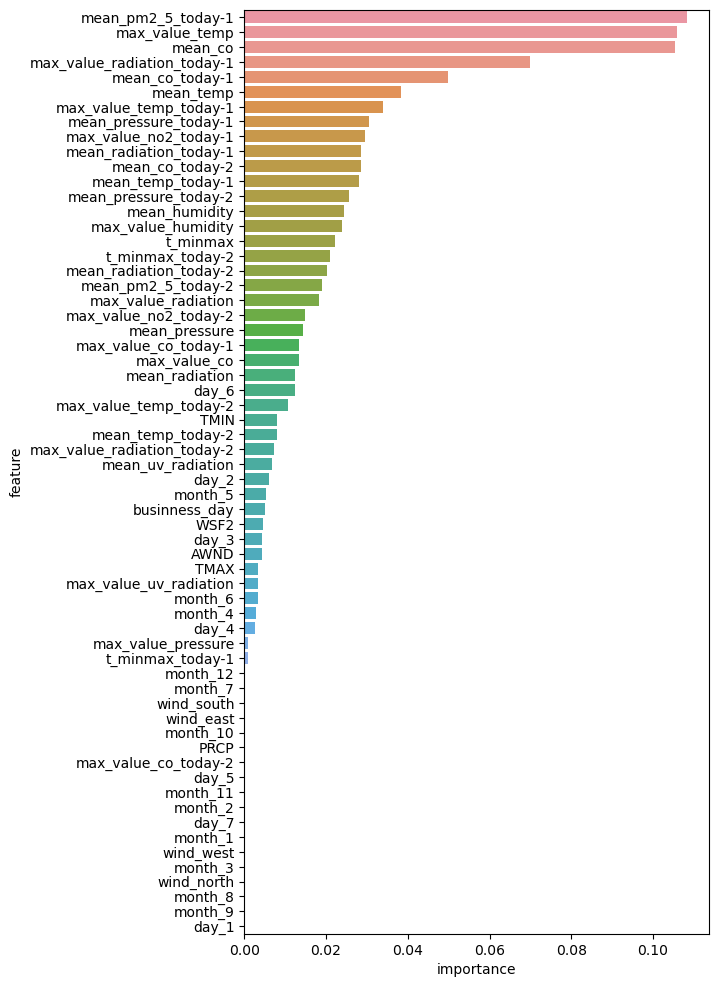

In [41]:
adaboost_data=pd.DataFrame(data={"importance":adaboost_aqimax_search.best_estimator_.feature_importances_,"feature":adaboost_aqimax_search.best_estimator_.feature_names_in_})
adaboost_data=adaboost_data.sort_values("importance",ascending=False)
fig,ax=plt.subplots(1,1,figsize=(6,12))
ax=sns.barplot(x=adaboost_data["importance"],y=adaboost_data.feature,orient="h")

Adaboost kann zeigt eine schlechtere Performance im Vergleich zu GBC. Modell sollte nicht gewählt werden. 